In [1]:
import os
import re
import sys

import h5py
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks')

#SED Variant Scoring functions below

#Function to read eQTL dataframe (storing scores at SNP-gene level)
def read_eqtl_sed(tissue, gtex_vcf_dir, pip_t=0.9):
    """Reads eQTLs from SUSIE output.
    
    Args:
        tissue (str): Tissue name.
        gtex_vcf_dir (str): GTEx VCF directory.
        pip_t (float): PIP threshold.

    Returns:
        eqtl_df (pd.DataFrame): eQTL dataframe, or None if tissue skipped.
    """
    
    susie_dir = '/home/drk/seqnn/data/gtex_fine/tissues_susie'

    #Read causal variants
    eqtl_file = f'{susie_dir}/{tissue}.tsv'
    df_eqtl = pd.read_csv(eqtl_file, sep='\t', index_col=0)

    #PIP filter
    pip_match = re.search(r"_pip(\d+).?$", gtex_vcf_dir).group(1)
    
    pip_t = float(pip_match) / 100
    assert(pip_t > 0 and pip_t <= 1)
    
    df_causal = df_eqtl[df_eqtl.pip > pip_t]
    
    #Make table
    tissue_vcf_file = f'{gtex_vcf_dir}/{tissue}_pos.vcf'
    if not os.path.isfile(tissue_vcf_file):
        eqtl_df = None
    else:
        #Create dataframe with SNP-gene coefficients
        eqtl_df = pd.DataFrame({
            'variant': df_causal.variant,
            'gene': [trim_dot(gene_id) for gene_id in df_causal.gene],
            'coef': df_causal.beta_posterior,
            'allele1': df_causal.allele1
        })
    
    return eqtl_df

#Function to remove the trailing dot from gene ids
def trim_dot(gene_id):
    """Trim dot off GENCODE id's."""
    
    dot_i = gene_id.rfind('.')
    
    #Remove dot if it was found
    if dot_i != -1:
        gene_id = gene_id[:dot_i]
    
    return gene_id

#Function to read Borzoi SED (or logSED) variant effect predictions
def read_borzoi_sed(gtex_scores_file, keyword, eqtl_df, score_key='SED', verbose=False):
    """Read eQTL RNA predictions for the given tissue.
    
    Args:
        gtex_scores_file (str): Variant scores HDF5.
        tissue_keyword (str): tissue keyword, for matching GTEx targets
        eqtl_df (pd.DataFrame): eQTL dataframe
        score_key (str): score key in HDF5 file
        verbose (bool): Print matching targets.

    Returns:
        eqtl_df (pd.DataFrame): eQTL dataframe, with added scores
    """
    
    #Read variant scores
    with h5py.File(gtex_scores_file, 'r') as gtex_scores_h5:
        
        #Extract metadata
        snp_i = gtex_scores_h5['si'][:]
        snps = np.array([snp.decode('UTF-8') for snp in gtex_scores_h5['snp']])
        ref_allele = np.array([ref.decode('UTF-8') for ref in gtex_scores_h5['ref_allele']])
        genes = np.array([snp.decode('UTF-8') for snp in gtex_scores_h5['gene']])
        target_ids = np.array([ref.decode('UTF-8') for ref in gtex_scores_h5['target_ids']])
        target_labels = np.array([ref.decode('UTF-8') for ref in gtex_scores_h5['target_labels']])
        
        #Determine matching GTEx targets
        match_tis = []
        for ti in range(len(target_ids)):
            if target_ids[ti].find('GTEX') != -1 and target_labels[ti].find(keyword) != -1:
                if not keyword == 'blood' or target_labels[ti].find('vessel') == -1:
                    if verbose:
                        print(ti, target_ids[ti], target_labels[ti])
                    match_tis.append(ti)
        match_tis = np.array(match_tis)
        
        #Read scores and take mean across targets
        score_table = gtex_scores_h5[score_key][...,match_tis].mean(axis=-1, dtype='float32')
        score_table = np.arcsinh(score_table)

    #Hash scores to (snp,gene)
    snpgene_scores = {}
    
    #Loop over rows in variant table
    for sgi in range(score_table.shape[0]):
        snp = snps[snp_i[sgi]]
        gene = trim_dot(genes[sgi])
        snpgene_scores[(snp,gene)] = score_table[sgi]

    #Add scores to eQTL table (flipping when allele1 doesn't match)
    snp_ref = dict(zip(snps, ref_allele))
    eqtl_df_scores = []
    
    #Loop over rows in eQTL dataframe
    for sgi, eqtl in eqtl_df.iterrows():
        sgs = snpgene_scores.get((eqtl.variant,eqtl.gene), 0) #np.nan)
        if not np.isnan(sgs) and sgs != 0 and snp_ref[eqtl.variant] != eqtl.allele1:
            sgs *= -1
        eqtl_df_scores.append(sgs)
    
    return eqtl_df_scores


In [2]:
#Load westminster scripts (gtex coefficient helper functions)

sys.path.append('/home/drk/code/westminster/src/westminster/scripts/')
from westminster_gtex_coef import read_eqtl


In [3]:
#Define folders with SNP predictions

gtex_vcf_dir = '/home/drk/seqnn/data/gtex_fine/susie_pip90r'
borzoi_dir = '/home/jlinder/analysis/bench_apa/test_apa'
borzoi_gtex_dir = '%s/ens_f3e4/gtexrg' % borzoi_dir


In [4]:
#Load SNP filter lists (train or test windows from hg38)

filter_file_train = '/home/jlinder/analysis/bench_apa/gtex_susie_pip90_f3c0_train.txt'
filter_file_test = '/home/jlinder/analysis/bench_apa/gtex_susie_pip90_f3c0_test.txt'

#Filter lists
snp_list_train = pd.read_csv(filter_file_train, sep='\t', names=['variant'])['variant'].values.tolist()
snp_list_test = pd.read_csv(filter_file_test, sep='\t', names=['variant'])['variant'].values.tolist()


In [5]:
# Enformer supplement
# tissue_keywords = {
#     'Adipose_Subcutaneous': 'adipose',
#     'Esophagus_Mucosa': 'esophagus',
#     'Skin_Not_Sun_Exposed_Suprapubic': 'skin',
#     'Testis': 'testis',
#     'Thyroid': 'thyroid',
#     'Whole_Blood': 'blood',
# }
# Extended set
tissue_keywords = {
      'Adipose_Subcutaneous': 'adipose',
      'Breast_Mammary_Tissue': 'breast',
      'Colon_Transverse': 'colon',
      'Esophagus_Mucosa': 'esophagus',
      'Liver': 'liver',
      'Lung': 'lung',
      'Muscle_Skeletal': 'muscle',
      'Ovary': 'ovary',
      'Pancreas': 'pancreas',
      'Pituitary': 'pituitary',
      'Prostate': 'prostate',
      'Skin_Not_Sun_Exposed_Suprapubic': 'skin',
      'Spleen': 'spleen',
      'Testis': 'testis',
      'Thyroid': 'thyroid',
      'Whole_Blood': 'blood'
}


In [6]:
#Append Borzoi Spearman correlation metrics

metrics_tissue = []
metrics_method = []
metrics_r = []

#Loop over tissues and prediction keywords
for tissue, keyword in tissue_keywords.items():
    print(tissue)

    #Read causal variants
    eqtl_df = read_eqtl_sed(tissue, gtex_vcf_dir)
    
    #Get SNP consistentcy flag from non-SED version of eQTL dataframe
    eqtl_df_consistent = read_eqtl(tissue, gtex_vcf_dir)[['variant', 'consistent']]
    consistent_dict = {}
    
    #Loop over eQTL dataframe rows
    for _, row in eqtl_df_consistent.iterrows() :
        consistent_dict[row['variant']] = row['consistent']
    
    consistent = []
    
    #Loop over rows again and mark consistent rows
    for _, row in eqtl_df.iterrows() :
        if row['variant'] in consistent_dict :
            consistent.append(consistent_dict[row['variant']])
        else :
            consistent.append(False)
    
    eqtl_df['consistent'] = consistent
    
    #Filter SNPs
    keep_index_train = eqtl_df.consistent & eqtl_df['variant'].isin(snp_list_train)
    keep_index_test = eqtl_df.consistent & eqtl_df['variant'].isin(snp_list_test)
    
    #Do not evaluate tissues with small number of held-out SNPs
    if np.sum(keep_index_test) < 200:
        print("[skipped, n = " + str(np.sum(keep_index_test)) + "]")
        continue
    
    variant_coef_train = eqtl_df[keep_index_train].coef
    variant_coef_test = eqtl_df[keep_index_test].coef
    
    ################################
    #Read Borzoi predictions
    gtex_scores_file = f'{borzoi_gtex_dir}/{tissue}_pos/sed.h5'
    borzoi_scores = read_borzoi_sed(gtex_scores_file, keyword, eqtl_df, 'logSED')
    
    borzoi_scores_train = np.array(borzoi_scores)[keep_index_train]
    borzoi_scores_test = np.array(borzoi_scores)[keep_index_test]

    #Compute Spearman correlation
    borzoi_r_train = spearmanr(variant_coef_train, borzoi_scores_train)[0]
    borzoi_r_test = spearmanr(variant_coef_test, borzoi_scores_test)[0]

    #Append tissues and correlation metrics (train)
    metrics_tissue.append(tissue)
    metrics_method.append('Borzoi (trained-on loci)')
    metrics_r.append(borzoi_r_train)
    
    #Append tissues and correlation metrics (test)
    metrics_tissue.append(tissue)
    metrics_method.append('Borzoi (held-out loci)')
    metrics_r.append(borzoi_r_test)


Adipose_Subcutaneous
Breast_Mammary_Tissue
Colon_Transverse
Esophagus_Mucosa
Liver
[skipped, n = 87]
Lung
Muscle_Skeletal
Ovary
[skipped, n = 107]
Pancreas
Pituitary
[skipped, n = 177]
Prostate
[skipped, n = 138]
Skin_Not_Sun_Exposed_Suprapubic
Spleen
Testis
Thyroid
Whole_Blood


In [7]:
#Construct dataframe with metrics

metrics_df = pd.DataFrame({
    'tissue': metrics_tissue,
    'method': metrics_method,
    'spearmanr': metrics_r
})

#Print summary
metrics_borzoi_df_train = metrics_df[metrics_df.method=='Borzoi (trained-on loci)']
metrics_borzoi_df_test = metrics_df[metrics_df.method=='Borzoi (held-out loci)']

print('Borzoi (train):   %.4f' % metrics_borzoi_df_train.spearmanr.mean())
print('Borzoi  (test):   %.4f' % metrics_borzoi_df_test.spearmanr.mean())


Borzoi (train):   0.3846
Borzoi  (test):   0.3667


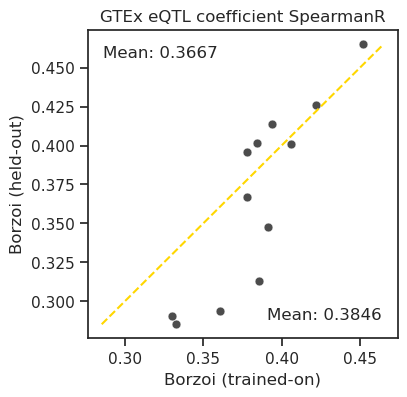

In [8]:
#Plot eQTL coefficient correlations (trained-on vs held-out)

plt.figure(figsize=(4,4))
plt.title('GTEx eQTL coefficient SpearmanR')
sns.scatterplot(x=metrics_borzoi_df_train.spearmanr.values,
                y=metrics_borzoi_df_test.spearmanr.values,
                color='black', alpha=0.7, s=40)
ax = plt.gca()

ax.text(0.95, 0.05, 'Mean: %.4f' % metrics_borzoi_df_train.spearmanr.mean(), 
                horizontalalignment='right', verticalalignment='bottom',
                transform=ax.transAxes)
ax.text(0.05, 0.95, 'Mean: %.4f' % metrics_borzoi_df_test.spearmanr.mean(), 
                horizontalalignment='left', verticalalignment='top',
                transform=ax.transAxes)

vmin = min(metrics_borzoi_df_train.spearmanr.min(), metrics_borzoi_df_test.spearmanr.min())
vmax = max(metrics_borzoi_df_train.spearmanr.max(), metrics_borzoi_df_test.spearmanr.max())
ax.plot([vmin,vmax], [vmin,vmax], linestyle='--', c='gold')

ax.set_xlabel('Borzoi (trained-on)')
ax.set_ylabel('Borzoi (held-out)')

plt.savefig('eqtl_coef_scatter_train_vs_test_sed.pdf')


In [11]:
#Print list of Spearman correlation metrics (train)
metrics_borzoi_df_train


,tissue,method,spearmanr
0,Adipose_Subcutaneous,Borzoi (trained-on loci),0.385401
2,Breast_Mammary_Tissue,Borzoi (trained-on loci),0.405974
4,Colon_Transverse,Borzoi (trained-on loci),0.377702
6,Esophagus_Mucosa,Borzoi (trained-on loci),0.378046
8,Lung,Borzoi (trained-on loci),0.391162
10,Muscle_Skeletal,Borzoi (trained-on loci),0.360553
12,Pancreas,Borzoi (trained-on loci),0.384543
14,Skin_Not_Sun_Exposed_Suprapubic,Borzoi (trained-on loci),0.393645
16,Spleen,Borzoi (trained-on loci),0.422234
18,Testis,Borzoi (trained-on loci),0.332759


In [12]:
#Print list of Spearman correlation metrics (test)
metrics_borzoi_df_test


,tissue,method,spearmanr
1,Adipose_Subcutaneous,Borzoi (held-out loci),0.313212
3,Breast_Mammary_Tissue,Borzoi (held-out loci),0.400889
5,Colon_Transverse,Borzoi (held-out loci),0.367044
7,Esophagus_Mucosa,Borzoi (held-out loci),0.395722
9,Lung,Borzoi (held-out loci),0.347869
11,Muscle_Skeletal,Borzoi (held-out loci),0.293931
13,Pancreas,Borzoi (held-out loci),0.401495
15,Skin_Not_Sun_Exposed_Suprapubic,Borzoi (held-out loci),0.413730
17,Spleen,Borzoi (held-out loci),0.425672
19,Testis,Borzoi (held-out loci),0.285356
